In [1]:
import pandas as pd

In [2]:
mapping = pd.read_csv("mapping.csv")
lookup = { mapping.iloc[i]["from"]: mapping.iloc[i]["to"]  for i in mapping.index}
lookup

{'8a3399aec8341c0766a49826a023bb6b24562ec1': 'be9474a1320a2585581151aa211cf662595f593e',
 'a1e77a023e1449d6f1d6bb4fc321e537c1c91432': '566fe922671b6a1941400d381e63ce20c04d953a',
 '7ee02cf2e1405fb376a7f0d9f10c53628ba18373': '1c0a15bde391be864031fabdfb0389a2d5e5d8df',
 '9f0a5c0e2efd594dfc93a7440f8965860b0fcfe0': 'ae9b5426c6c3da90531945dd539dee95f7a35cff',
 '38443e531a68d35f9c3be2fcdbe749b3da232963': '130f2baf932c7ea9c2885581b92b420091c7ce63',
 '379714315d504754bc5ad0bc17ab6d224adf4ae6': '7d866c4b30d7b7c8c31a347dcf57c7955ab1082b',
 '1b4b4c68c4ede676834ce62eb2d1f014fe3489a7': '8bf99138fb408c0dd7a1a5943501e663a0b6869f',
 'ac66a6b3dca0510e3e01eec02395966ef3e073fb': '493ea74d5ad644d33ddf1b3471e9f6bb73c4ad95',
 '1015838d6236681eee5655117636eda4d1156430': '6d0790cfa73049e6e99be7ccc7cff7ee2bda35c5',
 '710dd9ab31c32670b0657d30b7b7a222b2d07593': '873bf59b46df636cf9a228455ce47bacbf98f566',
 '0c688cf10cba27a4b603fe51257ce80cc9cb8589': '9a92e6f75686a564aae4632e5518d6a942cd0b58',
 '05de44d435b198e643a

In [3]:
before = pd.read_csv("outputt2.csv")
after = pd.read_csv("outputt.csv")


In [4]:
lookup['011fad3dc5cd82ee511b196130f5ea7b54cc6ea0']

'c8876b959f65f3eedcc4b35700398d8aaece0452'

In [5]:
before

,commit_hash,num_additions,num_deletions,filename
0,011fad3dc5cd82ee511b196130f5ea7b54cc6ea0,23,2,src/main/java/com/bittercode/util/StoreUtil.java
1,011fad3dc5cd82ee511b196130f5ea7b54cc6ea0,15,5,src/main/java/servlets/CartServlet.java
2,011fad3dc5cd82ee511b196130f5ea7b54cc6ea0,48,17,src/main/java/servlets/ViewBookServlet.java
3,7f69dcee1135798e8b06e2fbf8539f7f04adb6d6,8,6,README.md
4,59e4f86a4d265dd166aaabb5fd3277b07668881f,3,3,WebContent/Sample.html
...,...,...,...,...
540,a1e77a023e1449d6f1d6bb4fc321e537c1c91432,75,0,OnlineBookStore/src/test/ReceiptServlet.java
541,a1e77a023e1449d6f1d6bb4fc321e537c1c91432,39,0,OnlineBookStore/src/test/RemoveBookServlet.java
542,a1e77a023e1449d6f1d6bb4fc321e537c1c91432,42,0,OnlineBookStore/src/test/UserLoginServlet.java
543,a1e77a023e1449d6f1d6bb4fc321e537c1c91432,47,0,OnlineBookStore/src/test/UserRegisterServlet.java


In [11]:
after = after.set_index("commit_hash","filename")
after

num_additions  \
commit_hash                              filename                                                          
c8876b959f65f3eedcc4b35700398d8aaece0452 src/main/java/com/bittercode/util/StoreUtil.java             21   
                                         src/main/java/servlets/CartServlet.java                      12   
                                         src/main/java/servlets/ViewBookServlet.java                  65   
673aaee97c59baaccc653a37e6989bd01297e78c README.md                                                     8   
29db0fdb898d8e9a67ba6d9d606f2e8e7bcf26b0 WebContent/Sample.html                                        3   
...                                                                                                  ...   
566fe922671b6a1941400d381e63ce20c04d953a OnlineBookStore/src/test/ReceiptServlet.java                450   
                                         OnlineBookStore/src/test/RemoveBookServlet.java             208   
                                         OnlineBookStore/src/test/UserLoginServlet.java              240   
                                         OnlineBookStore/src/test/UserRegisterServlet.java           313   
                                         OnlineBookStore/src/test/ViewBookServlet.java               302   

                                                                                           num_deletions  
commit_hash                              filename                                                         
c8876b959f65f3eedcc4b35700398d8aaece0452 src/main/java/com/bittercode/util/StoreUtil.java              0  
                                         src/main/java/servlets/CartServlet.java                       6  
                                         src/main/java/servlets/ViewBookServlet.java                  49  
673aaee97c59baaccc653a37e6989bd01297e78c README.md                                                     6  
29db0fdb898d8e9a67ba6d9d606f2e8e7bcf26b0 WebContent/Sample.html                                        3  
...                                                                                                  ...  
566fe922671b6a1941400d381e63ce20c04d953a OnlineBookStore/src/test/ReceiptServlet.java                  0  
                                         OnlineBookStore/src/test/RemoveBookServlet.java               0  
                                         OnlineBookStore/src/test/UserLoginServlet.java                0  
                                         OnlineBookStore/src/test/UserRegisterServlet.java             0  
                                         OnlineBookStore/src/test/ViewBookServlet.java                 0  

[537 rows x 2 columns]

In [18]:

# set type of num_additions and num_deletions to int in after, setting bad cases to 0
after["num_additions"] = pd.to_numeric(after["num_additions"], errors='coerce')
after["num_deletions"] = pd.to_numeric(after["num_deletions"], errors='coerce')


AttributeError: 'DataFrame' object has no attribute 'sort'

<Axes: xlabel='commit_hash,filename'>

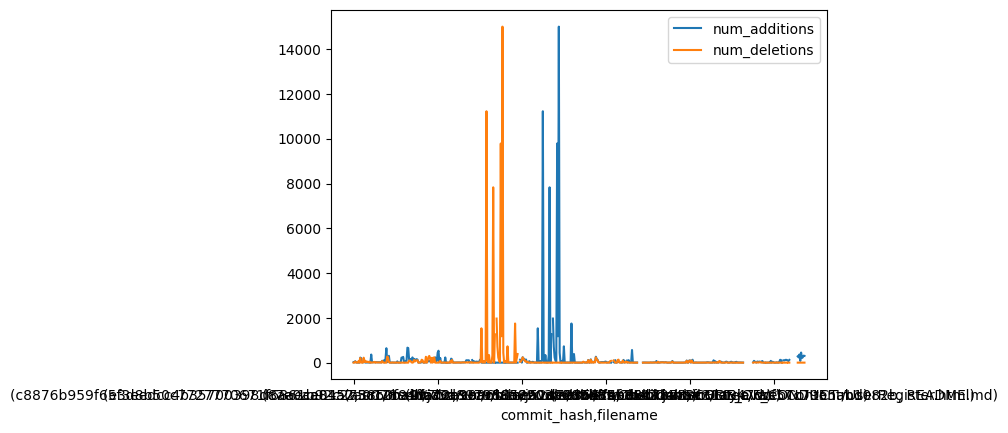

In [22]:
after.plot()
